In [1]:
import geopandas as gpd
import networkx as nx
from libpysal.weights import Queen, KNN

import numpy as np
from scipy.spatial.distance import pdist, squareform

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
gdf = gpd.read_file('C:/Users/13532/pycode/huawei/data/矢量/grid.shp')

In [3]:
gdf

,index_righ,name,childrenNu,level,code,filename,fullname,bbox,geometry
0,30,??,24.0,province,650000.0,650000,????????,"[ [ 73.502354999999994, 49.182341999999998 ], ...","POLYGON ((73.45570 38.44871, 73.45570 38.94871..."
1,30,??,24.0,province,650000.0,650000,????????,"[ [ 73.502354999999994, 49.182341999999998 ], ...","POLYGON ((73.45570 38.94871, 73.45570 39.44871..."
2,30,??,24.0,province,650000.0,650000,????????,"[ [ 73.502354999999994, 49.182341999999998 ], ...","POLYGON ((73.45570 39.44871, 73.45570 39.94871..."
3,30,??,24.0,province,650000.0,650000,????????,"[ [ 73.502354999999994, 49.182341999999998 ], ...","POLYGON ((73.45570 39.94871, 73.45570 40.44871..."
4,30,??,24.0,province,650000.0,650000,????????,"[ [ 73.502354999999994, 49.182341999999998 ], ...","POLYGON ((73.95570 38.44871, 73.95570 38.94871..."
...,...,...,...,...,...,...,...,...,...
5205,34,???,NaN,None,NaN,None,None,None,"POLYGON ((125.45570 21.94871, 125.45570 22.448..."
5206,34,???,NaN,None,NaN,None,None,None,"POLYGON ((125.95570 21.94871, 125.95570 22.448..."
5207,34,???,NaN,None,NaN,None,None,None,"POLYGON ((125.95570 22.44871, 125.95570 22.948..."
5208,34,???,NaN,None,NaN,None,None,None,"POLYGON ((126.45570 22.44871, 126.45570 22.948..."


## 空间权重矩阵
- 参考: [A graph neural network framework for spatial geodemographic classification](https://www.tandfonline.com/doi/full/10.1080/13658816.2023.2254382)  

- 使用图神经网络进行空间预测

In [4]:
def haversine(coord1, coord2):#哈弗赛因公式 完美的球体
    # 地球半径，单位为公里
    R = 6371.0  
    lat1, lon1 = np.radians(coord1)#coord1: 第一个点的经纬度坐标，格式为 (纬度, 经度)
    lat2, lon2 = np.radians(coord2)#coord2: 第二个点的经纬度坐标，格式为 (纬度, 经度)

    #计算两个纬度之间的差值
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    a = np.sin(dlat / 2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    
    return R * c  # 返回距离，单位为公里

### Queen’s contiguity

In [5]:
w = Queen.from_dataframe(gdf, use_index=True)  #  构建邻接矩阵 (Queen 邻接关系)
adj_matrix = w.sparse  # 将邻接矩阵转换为稀疏矩阵格式

D:\Anaconda\envs\huawei_math\lib\site-packages\libpysal\weights\weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 6 disconnected components.
 There is 1 island with id: 4696.
  warnings.warn(message)


C:\Users\13532\AppData\Local\Temp\ipykernel_41200\2700156124.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.geometry.centroid


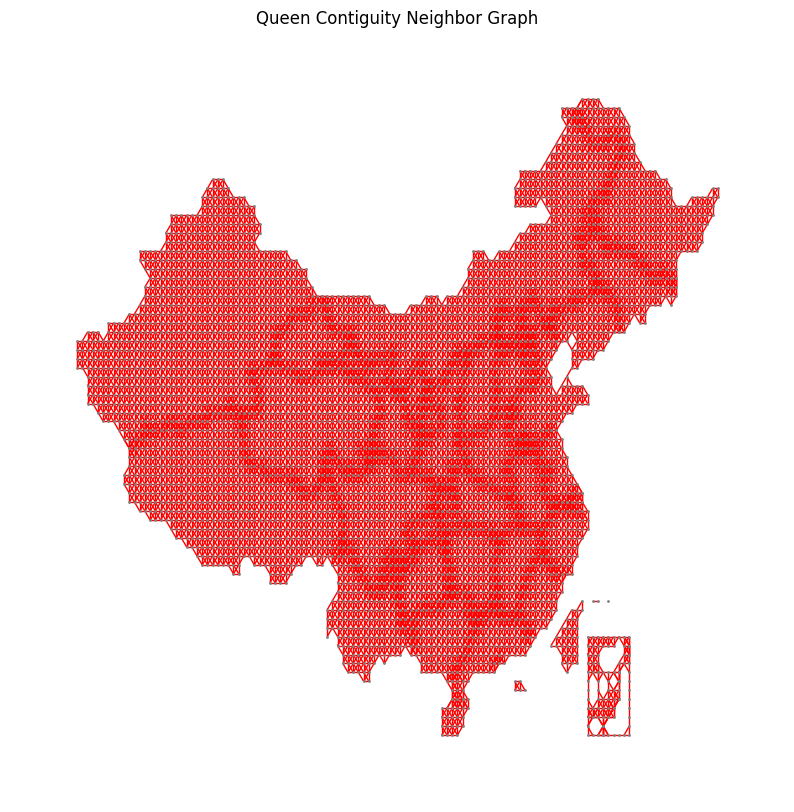

In [6]:
G = nx.from_numpy_array(adj_matrix)
# 提取几何的中心点作为节点位置
centroids = gdf.geometry.centroid
pos = {i: (centroid.x, centroid.y) for i, centroid in enumerate(centroids)}

# 绘制图形
fig, ax = plt.subplots(figsize=(10, 10))
# gdf.boundary.plot(ax=ax, linewidth=1, edgecolor='black')
nx.draw(
    G, pos,
    ax=ax,
    node_size=1,
    node_color="grey",
    edge_color="red",
    with_labels=False
)
plt.title('Queen Contiguity Neighbor Graph')
plt.show()

In [7]:
centroids = gdf.geometry.centroid  # 获取每个要素的几何中心点
coords = centroids.apply(lambda point: (point.y, point.x)).tolist()  # 提取经纬度
dist_matrix = squareform(pdist(coords, metric=haversine))  # 使用 pdist 和 haversine 计算距离矩阵
# 使用距离的倒数作为权重矩阵
weight_matrix = 1 / (dist_matrix + np.eye(dist_matrix.shape[0]))  # 避免除以 0

C:\Users\13532\AppData\Local\Temp\ipykernel_41200\1893170252.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.geometry.centroid  # 获取每个要素的几何中心点
C:\Users\13532\AppData\Local\Temp\ipykernel_41200\1893170252.py:5: RuntimeWarning: divide by zero encountered in divide
  weight_matrix = 1 / (dist_matrix + np.eye(dist_matrix.shape[0]))  # 避免除以 0


In [8]:
weight_matrix

array([[1.00000000e+00, 1.79864321e-02, 8.99321606e-03, ...,
        1.90575227e-04, 1.89015546e-04, 1.90080161e-04],
       [1.79864321e-02, 1.00000000e+00, 1.79864321e-02, ...,
        1.90429676e-04, 1.88884076e-04, 1.89967198e-04],
       [8.99321606e-03, 1.79864321e-02, 1.00000000e+00, ...,
        1.90268191e-04, 1.88737091e-04, 1.89838315e-04],
       ...,
       [1.90575227e-04, 1.90429676e-04, 1.90268191e-04, ...,
        1.00000000e+00, 1.94965084e-02, 1.32311726e-02],
       [1.89015546e-04, 1.88884076e-04, 1.88737091e-04, ...,
        1.94965084e-02, 1.00000000e+00, 1.79864321e-02],
       [1.90080161e-04, 1.89967198e-04, 1.89838315e-04, ...,
        1.32311726e-02, 1.79864321e-02, 1.00000000e+00]])

In [10]:
weight_matrix.shape

(5210, 5210)

### K-nearest neighbours (KNN)

In [11]:
# 使用KNN构建邻接矩阵，k表示邻居个数
k = 7
knn = KNN.from_dataframe(gdf, k=k)
adj_matrix = knn.sparse

C:\Users\13532\AppData\Local\Temp\ipykernel_41200\2338306677.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.geometry.centroid


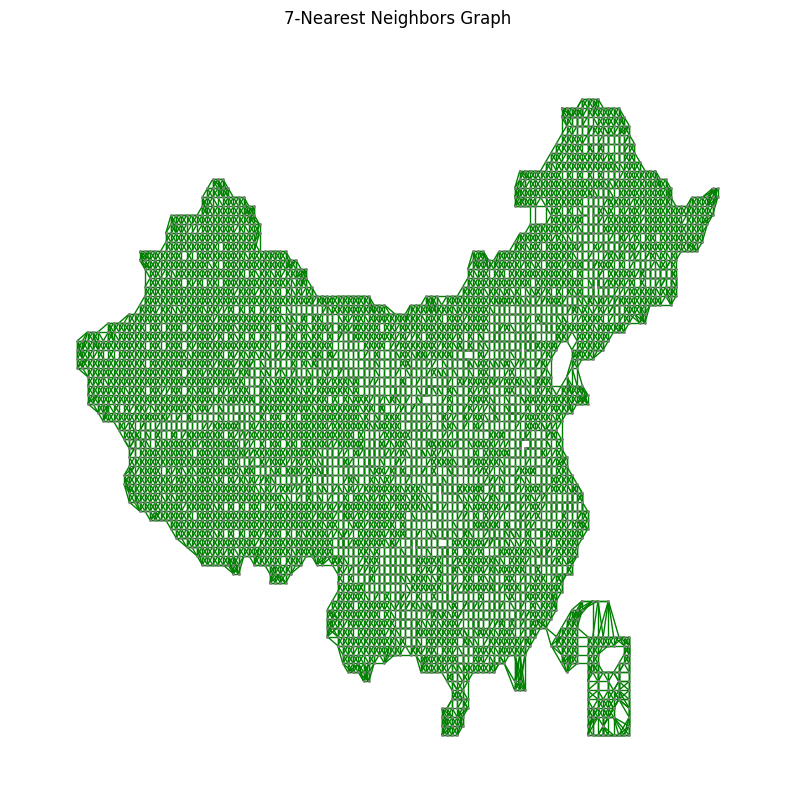

In [12]:
G = nx.from_numpy_array(adj_matrix)

centroids = gdf.geometry.centroid
pos = {i: (centroid.x, centroid.y) for i, centroid in enumerate(centroids)}

# 绘制图形
fig, ax = plt.subplots(figsize=(10, 10))
nx.draw(
    G, pos,
    ax=ax,
    node_size=1,
    node_color="grey",
    edge_color="green",
    with_labels=False
)
plt.title(f'{k}-Nearest Neighbors Graph')
plt.show()

### 数据加载和预处理

In [14]:
import pandas as pd
import geopandas as gpd
import numpy as np
from sklearn.preprocessing import StandardScaler

# 假设已经有1990到2015年的人口和GDP数据、1990到2020年的降雨量、温度和土地利用数据
years_pop_gdp = range(1990, 2016)
years_env = range(1990, 2021)

def load_csv_files(base_path, year):
    # 加载人口或GDP数据
    file_path = f"{base_path}/人口/pop{year}.csv"
    return pd.read_csv(file_path)

def load_environmental_data(base_path, year):
    # 加载降雨量、温度和土地利用类型数据
    rainfall_path = f"{base_path}/降雨/rain_{year}.csv"
    temperature_path = f"{base_path}/温度/temperature_{year}.csv"
    landuse_path = f"{base_path}/土地利用/landuse_{year}.csv"

    rainfall_data = pd.read_csv(rainfall_path)
    temperature_data = pd.read_csv(temperature_path)
    landuse_data = pd.read_csv(landuse_path)

    return rainfall_data, temperature_data, landuse_data

# 合并所有年份的数据
def merge_yearly_data(base_path):
    all_data = []
    
    for year in years_pop_gdp:
        pop_data = load_csv_files(base_path, year, 'pop')
        gdp_data = load_csv_files(base_path, year, 'gdp')
        merged_pop_gdp = pd.merge(pop_data, gdp_data, on='FID')
        
        rainfall_data, temp_data, landuse_data = load_environmental_data(base_path, year)
        
        # 合并环境数据
        merged_env = pd.merge(pd.merge(rainfall_data, temp_data, on='FID'), landuse_data, on='FID')
        final_merged = pd.merge(merged_pop_gdp, merged_env, on='FID')
        
        final_merged['year'] = year
        all_data.append(final_merged)
        
    return pd.concat(all_data, axis=0)

# 假设数据存储路径
base_path = 'D:/研究生学习资料/比赛/华为杯/D数据集/data'
full_data = merge_yearly_data(base_path)


TypeError: load_csv_files() takes 2 positional arguments but 3 were given

In [24]:
import pandas as pd
import os

def load_csv_files(base_path, year, data_type):
    file_path = os.path.join(base_path, data_type, f'{data_type}{year}.csv')
    return pd.read_csv(file_path)

def load_environmental_data(base_path, year):
    rainfall_path = os.path.join(base_path, '降雨', f'rain_{year}.csv')
    temperature_path = os.path.join(base_path, '温度', f'temperature_{year}.csv')
    landuse_path = os.path.join(base_path, '土地利用', f'landuse_{year}.csv')
    
    rainfall_data = pd.read_csv(rainfall_path)
    temperature_data = pd.read_csv(temperature_path)
    landuse_data = pd.read_csv(landuse_path)

    return rainfall_data, temperature_data, landuse_data

def merge_yearly_data(base_path):
    for year in range(1990, 2021):  # 处理 1990-2020 年的数据
        if year <= 2015:  # 只合并 pop 和 gdp 数据在 1990-2015 年
            pop_data = load_csv_files(base_path, year, 'pop')
            gdp_data = load_csv_files(base_path, year, 'gdp')
            merged_pop_gdp = pd.merge(pop_data, gdp_data, on='FID')
        
        # 加载环境数据
        rainfall_data, temp_data, landuse_data = load_environmental_data(base_path, year)

        # 合并环境数据
        merged_env = pd.merge(pd.merge(rainfall_data, temp_data, on='FID'), landuse_data, on='FID')

        # 结合 pop/gdp 数据（如果存在）
        if year <= 2015:
            final_data = pd.merge(merged_pop_gdp, merged_env, on='FID')
        else:
            final_data = merged_env
        
        # 保存每年的合并数据
        final_data.to_csv(os.path.join(base_path, f'merged_data_{year}.csv'), index=False)

base_path = 'D:/研究生学习资料/比赛/华为杯/D数据集/data'
merge_yearly_data(base_path)


In [8]:
import pandas as pd

# 循环年份
for year in range(1990, 2021):
    # 加载每日数据
    data = pd.read_csv(f'D:/研究生学习资料/比赛/华为杯/D数据集/data/merged_data/merged_data_{year}.csv')

    # 转置数据，使日期成为列名
    data = data.transpose()

    # 将列名转换为字符串
    data.columns = data.columns.astype(str)

    # 提取月份
    monthly_data = {}
    
    for col in data.columns:
        # 提取月份（假设格式为YYYYMMDD）
        month = col[:6]  # 取前六位为年月
        if month not in monthly_data:
            monthly_data[month] = []
        monthly_data[month].append(data[col])

    # 计算每月平均值
    monthly_average = {month: pd.concat(values, axis=1).mean(axis=1) for month, values in monthly_data.items()}

    # 转换为DataFrame
    monthly_temperature = pd.DataFrame(monthly_average)

    # 保存每月温度数据
    monthly_temperature.to_csv(f'D:/研究生学习资料/比赛/华为杯/D数据集/data/monthly_temperature/monthly_temperature_{year}.csv', index=True)


KeyboardInterrupt: 

In [25]:
import pandas as pd
import os

# 假设数据存储路径
base_path = 'D:/研究生学习资料/比赛/华为杯/D数据集/data/merged_data'

def load_combined_data(year):
    """加载合并后的数据"""
    return pd.read_csv(os.path.join(base_path, f'merged_data_{year}.csv'))

def calculate_disaster_severity(combined_data):
    """根据降水量和其他因素计算灾情严重度"""
    # 假设根据某种规则计算严重度，这里简单示例
    combined_data['severity'] = combined_data.filter(like='TIF').apply(lambda row: (row > 50).sum(), axis=1)
    return combined_data[['FID', 'severity']]

# 循环处理1990到2020年的数据
years = range(1990, 2021)
all_severity_data = []

for year in years:
    # 读取数据
    combined_data = load_combined_data(year)
    
    # 计算灾情严重度
    disaster_severity = calculate_disaster_severity(combined_data)
    
    # 添加年份信息
    disaster_severity['year'] = year
    
    # 保存结果
    all_severity_data.append(disaster_severity)

# 合并所有年份的结果
final_severity_data = pd.concat(all_severity_data)

# 打印结果
print(final_severity_data.head())

# 保存到CSV文件
final_severity_data.to_csv(os.path.join(base_path, r'D:\研究生学习资料\比赛\华为杯\D数据集\data\disaster_severity_1990_2020.csv'), index=False)


C:\Users\13532\AppData\Local\Temp\ipykernel_41200\373852446.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  disaster_severity['year'] = year
C:\Users\13532\AppData\Local\Temp\ipykernel_41200\373852446.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  disaster_severity['year'] = year
C:\Users\13532\AppData\Local\Temp\ipykernel_41200\373852446.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

   FID  severity  year
0  0.0         0  1990
1  0.0         0  1990
2  0.0         0  1990
3  0.0         0  1990
4  0.0         0  1990


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import joblib

# 加载灾情预警数量数据
disaster_severity_data = pd.read_csv(r'D:\研究生学习资料\比赛\华为杯\D数据集\data\disaster_severity_1990_2020.csv')

# 准备数据函数
def prepare_data(data, severity_data):
    # 选择土地利用和温度列
    land_use_columns = [col for col in data.columns if any(col.startswith(type_) for type_ in ['cropland', 'forest', 'grass', 'shrub', 'buildup'])]
    temperature_columns = [col for col in data.columns if 'TIF' in col]
    
    # 合并特征和标签，确保通过FID匹配
    merged_data = data.merge(severity_data, on='FID', how='left')
    
    return merged_data, land_use_columns + temperature_columns

# 主程序
years = range(1990, 2021)
model = RandomForestRegressor(n_estimators=100, random_state=42)

# 每年读取数据并训练模型
for year in years:
    data = pd.read_csv(f'D:/研究生学习资料/比赛/华为杯/D数据集/data/merged_data/merged_data_{year}.csv', dtype={'column_name': 'float32'})
    merged_data, feature_columns = prepare_data(data, disaster_severity_data)
    
    for feature in feature_columns:
        # 特征X和标签y
        X = merged_data[[feature]].astype('float32')
        y = merged_data['severity']

        # 划分训练和测试集
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # 训练模型
        model.fit(X_train, y_train)

        # 保存模型
        joblib.dump(model, f'disaster_prediction_model_{year}_{feature}.pkl')

# 预测2025-2035年的成灾情况
future_years = range(2025, 2036)
predictions = []

# 生成未来数据并预测
for year in future_years:
    future_data = generate_future_data(year)
    if not future_data.empty:  # 确保未来数据不为空
        for feature in feature_columns:
            X_future = future_data[[feature]]
            preds = model.predict(X_future)
            predictions.append(preds)
    else:
        predictions.append(np.nan)  # 若未来数据为空，则记录为NaN

# 整理预测结果
predictions_df = pd.DataFrame(predictions, columns=[f'Prediction_{year}' for year in future_years])
predictions_df.to_csv('D:/研究生学习资料/比赛/华为杯/D数据集/data/disaster_predictions_2025_2035.csv', index=False)

# 函数生成未来数据的示例（需根据实际情况调整）
def generate_future_data(year):
    # 根据现有数据生成未来的土地利用和温度数据
    historical_data = pd.concat([pd.read_csv(f'D:/研究生学习资料/比赛/华为杯/D数据集/data/merged_data/merged_data_{yr}.csv') for yr in range(1990, 2021)])
    
    future_land_use = historical_data[[col for col in historical_data.columns if any(col.startswith(type_) for type_ in ['cropland', 'forest', 'grass', 'shrub', 'buildup'])]].mean()
    future_temperature = historical_data[[col for col in historical_data.columns if 'TIF' in col]].mean()

    future_data = pd.DataFrame([future_land_use.append(future_temperature)], columns=future_land_use.index.tolist() + future_temperature.index.tolist())
    return future_data  # 返回生成的未来数据



MemoryError: Unable to allocate 739. MiB for an array with shape (96905000,) and data type int64

### 数据标准化和处理邻接矩阵

In [ ]:
# 标准化处理
scaler = StandardScaler()
scaled_data = full_data.copy()
scaled_columns = ['pop', 'gdp', 'rainfall', 'temperature']  # 根据数据列修改
scaled_data[scaled_columns] = scaler.fit_transform(scaled_data[scaled_columns])


# 构建邻接矩阵，使用空间距离来定义邻居关系
from scipy.spatial.distance import pdist, squareform
from sklearn.neighbors import kneighbors_graph

coords = full_data[['lon', 'lat']].values  # 使用经纬度数据
dist_matrix = squareform(pdist(coords))
knn_graph = kneighbors_graph(coords, n_neighbors=7, mode='distance', include_self=False)

# 将邻接矩阵转为图结构
import networkx as nx
G = nx.from_scipy_sparse_matrix(knn_graph)


### 构建GNN

In [ ]:
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv

# 将 Pandas 数据框转化为 PyTorch Geometric 数据格式
def create_graph_data(df):
    # 节点特征 (使用经纬度、人口、GDP、降雨量、温度等作为特征)
    x = torch.tensor(df[['lon', 'lat', 'pop', 'gdp', 'rainfall', 'temperature']].values, dtype=torch.float)

    # 边 (邻接矩阵转为 PyTorch 张量格式)
    edge_index = torch.tensor(np.array(list(G.edges)).T, dtype=torch.long)

    # 创建图数据
    data = Data(x=x, edge_index=edge_index)
    return data

graph_data = create_graph_data(scaled_data)

# 定义 GCN 模型
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x

# 初始化模型
input_dim = 6  # 特征数（经纬度、人口、GDP等）
hidden_dim = 16
output_dim = 1  # 输出维度（预测）

model = GCN(input_dim, hidden_dim, output_dim)


### 训练

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 数据划分（训练集、验证集、测试集）
train_data, test_data = train_test_split(scaled_data, test_size=0.2, random_state=42)
val_data, test_data = train_test_split(test_data, test_size=0.5, random_state=42)

train_graph = create_graph_data(train_data)
val_graph = create_graph_data(val_data)
test_graph = create_graph_data(test_data)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# 假设你已经有一个DataLoader来加载经过预处理的图数据
# 准备图神经网络模型

class GNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNNModel, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

# 数据预处理部分
# 将人口、GDP、降水、温度和土地利用等特征数据组合起来
def load_and_preprocess_data():
    # 假设我们已经从每个年份的CSV文件中提取了特征
    data_features = ...  # 例如 shape 为 (n_samples, n_features)
    labels = ...  # 最后要预测的土地利用类型或其他目标变量
    
    # 对数据标准化
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data_features)

    return scaled_data, labels

# 创建图数据
def create_graph_data(data, labels):
    # 假设每个数据点都有对应的邻接关系和节点特征
    edge_index = ...  # 邻接矩阵边的索引，通常是个 (2, num_edges) 的数组
    x = torch.tensor(data, dtype=torch.float)
    y = torch.tensor(labels, dtype=torch.float)  # 最终要预测的土地利用类型
    return Data(x=x, edge_index=edge_index, y=y)

# 训练图神经网络的函数
def train_gnn_model(model, train_graph, optimizer, epochs=200):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        output = model(train_graph)
        loss = F.mse_loss(output, train_graph.y)  # 假设输出和目标的维度匹配
        loss.backward()
        optimizer.step()
        
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

# 定义测试函数
def test_gnn_model(model, test_graph):
    model.eval()
    with torch.no_grad():
        pred = model(test_graph)
        loss = F.mse_loss(pred, test_graph.y)
    return pred, loss.item()

# 加载并处理数据
data, labels = load_and_preprocess_data()

# 将数据拆分为训练集和测试集
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=42)

# 将训练数据和测试数据转换为图格式
train_graph = create_graph_data(train_data, train_labels)
test_graph = create_graph_data(test_data, test_labels)

# 模型参数
input_dim = train_data.shape[1]  # 特征维度
hidden_dim = 64  # 隐藏层维度
output_dim = 1  # 输出维度，假设预测一个连续值（例如土地利用的某个类型）

# 初始化模型
model = GNNModel(input_dim, hidden_dim, output_dim)

# 优化器
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

# 训练模型
train_gnn_model(model, train_graph, optimizer, epochs=200)

# 测试模型并进行预测
pred, test_loss = test_gnn_model(model, test_graph)
print(f"Test Loss: {test_loss:.4f}")

# 评估模型
pred = pred.cpu().numpy()
true_values = test_graph.y.cpu().numpy()

mse = mean_squared_error(true_values, pred)
r2 = r2_score(true_values, pred)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R² Score: {r2:.4f}")

# 可视化预测结果 vs. 真实值
plt.figure(figsize=(10, 6))
plt.scatter(true_values, pred, alpha=0.5)
plt.plot([true_values.min(), true_values.max()], [true_values.min(), true_values.max()], 'r--')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True Values vs Predictions')
plt.show()


In [ ]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

# 步骤 1: 数据加载
# 假设我们有多个CSV文件，按年份分别读取
population_data = {}
gdp_data = {}
rainfall_data = {}
land_use_data = {}
temperature_data = {}

# 读取1990-2015年的人口和GDP数据
for year in range(1990, 2016):
    population_data[year] = pd.read_csv(f'path/to/population_{year}.csv')
    gdp_data[year] = pd.read_csv(f'path/to/gdp_{year}.csv')

# 读取1990-2020年降雨量数据（假设为日数据，按年平均）
for year in range(1990, 2021):
    rainfall_data[year] = pd.read_csv(f'path/to/rainfall_{year}.csv')

# 读取土地利用数据（1990-2020，假设有多个文件）
for year in range(1990, 2021):
    land_use_data[year] = pd.read_csv(f'path/to/land_use_{year}.csv')

# 读取气温数据（假设为日数据，按年平均）
for year in range(1990, 2021):
    temperature_data[year] = pd.read_csv(f'path/to/temperature_{year}.csv')

# 步骤 2: 合并数据
combined_data = {}

for year in range(1990, 2021):
    combined_data[year] = pd.merge(population_data[year], gdp_data[year], on='FID')
    combined_data[year] = pd.merge(combined_data[year], rainfall_data[year], on='FID')
    combined_data[year] = pd.merge(combined_data[year], land_use_data[year], on='FID')
    combined_data[year] = pd.merge(combined_data[year], temperature_data[year], on='FID')

# 步骤 3: 分析数据并确定脆弱区域
def is_vulnerable(row):
    critical_rainfall = 50  # 临界降雨量
    rainfall = row['average_rainfall']  # 平均降雨量
    land_use = row['land_use_type']  # 土地利用类型
    
    if rainfall > critical_rainfall:
        if land_use in ['urban', 'agriculture']:  # 可能脆弱的土地利用类型
            return True
    return False

# 创建脆弱区域列表
vulnerable_areas = []

for year in range(1990, 2021):
    combined_data[year]['vulnerable'] = combined_data[year].apply(is_vulnerable, axis=1)
    vulnerable_areas.extend(combined_data[year][combined_data[year]['vulnerable']]['FID'].unique())

# 步骤 4: 可视化结果
# 假设 land_use_data[2020] 是 GeoDataFrame
vulnerable_gdf = land_use_data[2020][land_use_data[2020]['FID'].isin(vulnerable_areas)]

fig, ax = plt.subplots(figsize=(10, 10))
land_use_data[2020].plot(ax=ax, color='lightgrey')
vulnerable_gdf.plot(ax=ax, color='red', alpha=0.5)

plt.title('Predicted Vulnerable Areas to Rainstorm Disasters (2025-2035)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


In [ ]:
import pandas as pd
import geopandas as gpd
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv
import matplotlib.pyplot as plt

# 步骤 1: 数据加载
# ...（数据加载和合并的部分与之前相同）

# 步骤 2: 准备图数据
def create_graph_data(combined_data, year):
    # 假设我们有一个邻接矩阵（adjacency_matrix）和节点特征（node_features）
    # 这里的邻接矩阵和节点特征需要根据数据构建

    # 示例：构建一个简单的邻接矩阵
    num_nodes = len(combined_data)
    adjacency_matrix = np.zeros((num_nodes, num_nodes))

    # 填充邻接矩阵（根据某种逻辑，例如距离、土地利用相似性等）
    # 这里略去具体的逻辑

    # 构建节点特征，假设我们使用人口、GDP、降雨量作为特征
    node_features = combined_data[['population', 'GDP', 'average_rainfall']].values

    # 创建 PyG 数据对象
    edge_index = torch.tensor(adjacency_matrix.nonzero(), dtype=torch.long)
    x = torch.tensor(node_features, dtype=torch.float)
    data = Data(x=x, edge_index=edge_index)

    return data

# 创建图数据
year = 2020
data = create_graph_data(combined_data[year], year)

# 步骤 3: 定义 GNN 模型
class GNNModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNNModel, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

# 步骤 4: 训练模型
def train_model(data, num_epochs=100):
    model = GNNModel(input_dim=data.x.shape[1], hidden_dim=16, output_dim=1)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        
        # 使用某种损失函数，例如MSE
        loss = F.mse_loss(out, data.y)  # 假设 data.y 是标签
        loss.backward()
        optimizer.step()
        
        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')

    return model

# 训练 GNN 模型
trained_model = train_model(data)

# 步骤 5: 可视化预测结果
# 预测并绘制
model.eval()
predictions = trained_model(data.x, data.edge_index).detach().numpy()

# 进行地图可视化（与前面相同）
# 假设我们使用 predictions 进行可视化
vulnerable_gdf['predictions'] = predictions  # 将预测结果添加到 GeoDataFrame
fig, ax = plt.subplots(figsize=(10, 10))
land_use_data[2020].plot(ax=ax, color='lightgrey')
vulnerable_gdf[vulnerable_gdf['predictions'] > 0.5].plot(ax=ax, color='red', alpha=0.5)

plt.title('Predicted Vulnerable Areas to Rainstorm Disasters (2025-2035)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()
